In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import revsic_glowtts as glowtts
from malaya_speech.train.model.revsic_glowtts import model_stochastic
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [5]:
i = tf.placeholder(tf.int32, [None, None])
i_lengths = tf.placeholder(tf.int32, [None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])

In [6]:
config = glowtts.Config(mel = 80, vocabs = 66)
config.dur_dropout = 0.5

In [7]:
model = model_stochastic.Model(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
loss, losses, attn = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
loss, losses, attn

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor 'add_4:0' shape=() dtype=float32>,
 {'nll': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
  'durloss': <tf.Tensor 'Sum_6:0' shape=() dtype=float32>,
  'mel_': <tf.Tensor 'Reshape_2:0' shape=(?, ?, ?) dtype=float32>},
 <tf.Tensor 'StopGradient:0' shape=(?, ?, ?) dtype=float32>)

In [9]:
mel, mellen, attn_out = model(inputs = i, lengths = i_lengths)
mel, mellen, attn_out

(<tf.Tensor 'model/Reshape_50:0' shape=(?, ?, ?) dtype=float32>,
 <tf.Tensor 'model/mul_90:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'model/transpose:0' shape=(?, ?, ?) dtype=float32>)

In [10]:
parameters = {
    'optimizer_params': {'beta1': 0.9, 'beta2': 0.98, 'epsilon': 1e-9},
    'lr_policy_params': {
        'warmup_steps': 30000,
    },
}

def noam_schedule(step, learning_rate, channels, warmup_steps=4000):
    return learning_rate * channels ** -0.5 * \
            tf.minimum(step ** -0.5, step * warmup_steps ** -1.5)

def learning_rate_scheduler(global_step):
    return transformer_schedule(
        tf.cast(global_step, tf.float32),
        config.channels,
        **parameters['lr_policy_params'],
    )

In [11]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.9, 
                                   beta2 = 0.98, epsilon = 1e-9).minimize(loss)

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [13]:
%%time

o = sess.run(mel, feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 3.66 s, sys: 223 ms, total: 3.89 s
Wall time: 3.29 s


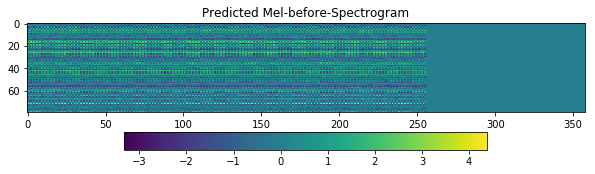

In [14]:
mel_outputs_ = np.reshape(o[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [16]:
%%time

o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 739 ms, sys: 146 ms, total: 885 ms
Wall time: 234 ms


In [17]:
for k in range(100):
    o = sess.run([loss, losses, optimizer], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})
    print(k, o)

0 [2.2786078, {'nll': 1.0257245, 'durloss': 1.2528834, 'mel_': array([[[ 3.6015203 ,  6.627657  ,  4.0235243 , ...,  3.3971543 ,
          2.067523  ,  3.8158216 ],
        [-1.7342939 , -4.9185047 , -0.96890485, ..., -2.765237  ,
         -0.843985  , -2.775251  ],
        [ 3.4721727 ,  6.3784323 ,  3.3668318 , ...,  3.2838683 ,
          2.0324275 ,  3.2942486 ],
        ...,
        [-1.5474002 , -5.178276  , -1.5474002 , ..., -5.178276  ,
         -1.5474002 , -5.178276  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 3.6015203 ,  6.627657  ,  4.0235243 , ...,  3.3971543 ,
          2.067523  ,  3.8158216 ],
        [-1.7342939 , -4.9185047 , -0.96890485, ..., -2.765237  ,
         -0.843985  , -2.775251  ],
        [ 3.4721727 ,  6.3784323 ,  3.3668318 , ...,  3.2838683 ,
          2.0324275 ,  3.2942486 ],
    

7 [1.8381357, {'nll': 0.3886854, 'durloss': 1.4494503, 'mel_': array([[[ 2.6646738 ,  4.5525837 ,  2.821068  , ...,  2.0751317 ,
          1.3918291 ,  2.5835474 ],
        [-0.9041369 , -3.0888586 , -0.21514279, ..., -1.919673  ,
         -0.34810162, -1.6637263 ],
        [ 2.5957048 ,  4.316816  ,  2.3980293 , ...,  1.9959476 ,
          1.4290364 ,  2.1660798 ],
        ...,
        [-0.5251167 , -2.9018447 , -0.52261955, ..., -3.3537843 ,
         -0.5475354 , -3.0057535 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
          0.        , -0.        ]],

       [[ 2.6646738 ,  4.5525837 ,  2.821068  , ...,  2.0751317 ,
          1.3918291 ,  2.5835474 ],
        [-0.9041369 , -3.0888586 , -0.21514279, ..., -1.919673  ,
         -0.34810162, -1.6637263 ],
        [ 2.5957048 ,  4.316816  ,  2.3980293 , ...,  1.9959476 ,
          1.4290364 ,  2.1660798 ],
    

14 [1.7831662, {'nll': 0.11116702, 'durloss': 1.6719991, 'mel_': array([[[ 1.1547005 ,  1.8970454 ,  1.2469453 , ...,  0.5310718 ,
          0.453313  ,  0.8995298 ],
        [ 0.12429032, -1.3811734 ,  0.4787644 , ..., -0.91366225,
          0.19455874, -0.4182902 ],
        [ 1.2034073 ,  1.7104803 ,  1.0662501 , ...,  0.48525196,
          0.5630777 ,  0.609924  ],
        ...,
        [ 0.4313973 , -1.327338  ,  0.17600384, ..., -1.9002547 ,
          0.2115787 , -1.2026641 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[ 1.1547005 ,  1.8970454 ,  1.2469453 , ...,  0.5310718 ,
          0.453313  ,  0.8995298 ],
        [ 0.12429032, -1.3811734 ,  0.4787644 , ..., -0.91366225,
          0.19455874, -0.4182902 ],
        [ 1.2034073 ,  1.7104803 ,  1.0662501 , ...,  0.48525196,
          0.5630777 ,  0.609924  ],
  

21 [1.5131835, {'nll': -0.19336832, 'durloss': 1.7065518, 'mel_': array([[[ 0.25944865,  0.5934442 ,  0.4837374 , ...,  0.00673011,
         -0.01594738,  0.30176938],
        [ 0.6695042 , -1.0629822 ,  0.7919713 , ..., -0.6077744 ,
          0.22178474,  0.21808597],
        [ 0.4120136 ,  0.2740696 ,  0.46337166, ..., -0.24557364,
          0.21055761, -0.17039093],
        ...,
        [ 0.8694323 , -1.9790133 ,  0.18915962, ..., -2.6106293 ,
          0.12728709, -1.1581925 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[ 0.25944865,  0.5934442 ,  0.4837374 , ...,  0.00673011,
         -0.01594738,  0.30176938],
        [ 0.6695042 , -1.0629822 ,  0.7919713 , ..., -0.6077744 ,
          0.22178474,  0.21808597],
        [ 0.4120136 ,  0.2740696 ,  0.46337166, ..., -0.24557364,
          0.21055761, -0.17039093],
 

28 [1.1747665, {'nll': -0.47326586, 'durloss': 1.6480324, 'mel_': array([[[-0.19225407,  0.35748494,  0.11312542, ...,  0.6788223 ,
         -0.21252376,  1.2265686 ],
        [ 1.354276  , -0.60932   ,  1.2154754 , ...,  0.5475595 ,
         -0.1582313 ,  1.4503877 ],
        [ 0.07849489, -0.15349337,  0.26927954, ...,  0.07945295,
          0.41277602,  0.1279653 ],
        ...,
        [ 1.783071  , -2.0743673 , -0.17125629, ..., -1.1384984 ,
         -0.552597  , -0.23717716],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.19225407,  0.35748494,  0.11312542, ...,  0.6788223 ,
         -0.21252376,  1.2265686 ],
        [ 1.354276  , -0.60932   ,  1.2154754 , ...,  0.5475595 ,
         -0.1582313 ,  1.4503877 ],
        [ 0.07849489, -0.15349337,  0.26927954, ...,  0.07945295,
          0.41277602,  0.1279653 ],
 

35 [1.0417994, {'nll': -0.62408006, 'durloss': 1.6658795, 'mel_': array([[[-0.28903604,  0.6225921 , -0.09886375, ...,  0.3043414 ,
         -0.46235567,  1.0284996 ],
        [ 1.295743  , -0.41261774,  0.89932   , ..., -0.01292993,
          0.16216339,  0.70211685],
        [-0.07671119, -0.01900543, -0.02501363, ..., -0.21234089,
          0.3166333 ,  0.00228167],
        ...,
        [ 1.661916  , -1.296911  , -0.79842556, ..., -1.3228042 ,
         -0.16113603, -1.1428158 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.28903604,  0.6225921 , -0.09886375, ...,  0.3043414 ,
         -0.46235567,  1.0284996 ],
        [ 1.295743  , -0.41261774,  0.89932   , ..., -0.01292993,
          0.16216339,  0.70211685],
        [-0.07671119, -0.01900543, -0.02501363, ..., -0.21234089,
          0.3166333 ,  0.00228167],
 

42 [0.9501228, {'nll': -0.70460397, 'durloss': 1.6547267, 'mel_': array([[[-0.34489757,  0.8906338 , -0.24627917, ...,  0.18985732,
         -0.6111624 ,  1.1452937 ],
        [ 0.93993044, -0.41329825,  1.4532238 , ..., -0.23190889,
          0.6199693 ,  0.21314645],
        [ 0.11776546,  0.11694691, -0.15669928, ..., -0.5237194 ,
          0.70119977, -0.19380167],
        ...,
        [ 1.7951114 , -0.7278299 , -0.07001463, ..., -0.52015394,
         -0.04921277, -1.1328909 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.34489757,  0.8906338 , -0.24627917, ...,  0.18985732,
         -0.6111624 ,  1.1452937 ],
        [ 0.93993044, -0.41329825,  1.4532238 , ..., -0.23190889,
          0.6199693 ,  0.21314645],
        [ 0.11776546,  0.11694691, -0.15669928, ..., -0.5237194 ,
          0.70119977, -0.19380167],
 

49 [0.8673425, {'nll': -0.7647662, 'durloss': 1.6321087, 'mel_': array([[[-0.5361211 ,  0.36646304, -0.94906986, ..., -0.47554463,
         -0.94016814,  1.1649283 ],
        [ 0.04120562, -1.3515438 ,  0.79753   , ..., -1.2857597 ,
          0.44306234, -0.03783657],
        [ 0.17093097, -0.18490624, -0.6890932 , ..., -1.0902413 ,
          0.8417662 , -0.52203584],
        ...,
        [ 0.8732584 , -1.6084974 , -0.48868063, ..., -2.333197  ,
         -1.7547674 , -1.1875182 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.5361211 ,  0.36646304, -0.94906986, ..., -0.47554463,
         -0.94016814,  1.1649283 ],
        [ 0.04120562, -1.3515438 ,  0.79753   , ..., -1.2857597 ,
          0.44306234, -0.03783657],
        [ 0.17093097, -0.18490624, -0.6890932 , ..., -1.0902413 ,
          0.8417662 , -0.52203584],
  

55 [0.7507739, {'nll': -0.8178469, 'durloss': 1.5686208, 'mel_': array([[[-0.44522485,  0.03260663, -0.8171737 , ...,  0.17472656,
         -1.0099533 ,  1.1059891 ],
        [-0.07579841, -1.281884  ,  0.33660138, ..., -0.535409  ,
          1.0491865 ,  0.0445976 ],
        [ 0.4581579 , -0.5889389 , -0.64916867, ..., -0.7020728 ,
          0.9822178 , -0.80314684],
        ...,
        [ 1.5838865 , -1.3580542 , -0.41263545, ..., -0.80769277,
         -0.986171  , -0.8831023 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.44522485,  0.03260663, -0.8171737 , ...,  0.17472656,
         -1.0099533 ,  1.1059891 ],
        [-0.07579841, -1.281884  ,  0.33660138, ..., -0.535409  ,
          1.0491865 ,  0.0445976 ],
        [ 0.4581579 , -0.5889389 , -0.64916867, ..., -0.7020728 ,
          0.9822178 , -0.80314684],
  

62 [0.68643224, {'nll': -0.87795484, 'durloss': 1.5643871, 'mel_': array([[[-0.9162953 ,  1.1183479 , -0.27912682, ...,  0.35041106,
         -0.8781268 ,  1.5887231 ],
        [-1.6189611 , -0.41223982,  0.37118226, ..., -0.2070087 ,
          1.2897507 ,  0.4025985 ],
        [ 0.42582077, -0.01403663, -0.30536017, ..., -0.6186964 ,
          1.6275439 , -0.66250134],
        ...,
        [ 1.0393112 , -0.9017505 , -0.09722269, ..., -1.1334054 ,
         -0.92991686, -0.77807075],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.9162953 ,  1.1183479 , -0.27912682, ...,  0.35041106,
         -0.8781268 ,  1.5887231 ],
        [-1.6189611 , -0.41223982,  0.37118226, ..., -0.2070087 ,
          1.2897507 ,  0.4025985 ],
        [ 0.42582077, -0.01403663, -0.30536017, ..., -0.6186964 ,
          1.6275439 , -0.66250134],


68 [0.65292716, {'nll': -0.926466, 'durloss': 1.5793931, 'mel_': array([[[-5.5363524e-01,  9.6699768e-01,  1.0169768e-01, ...,
          6.7774020e-02, -1.0374407e+00,  1.6589022e+00],
        [-2.2357390e+00, -6.0245001e-01,  1.3063246e-01, ...,
         -5.5381882e-01,  1.3600767e+00,  2.5653136e-01],
        [ 8.5406762e-01, -3.4549841e-01, -2.4697323e-01, ...,
         -9.4274622e-01,  1.7635801e+00, -8.5911524e-01],
        ...,
        [ 7.7750862e-01, -1.0991832e+00, -7.1108341e-05, ...,
         -1.8663007e+00, -9.0656769e-01, -1.0265317e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00]],

       [[-5.5363524e-01,  9.6699768e-01,  1.0169768e-01, ...,
          6.7774020e-02, -1.0374407e+00,  1.6589022e+00],
        [-2.2357390e+00, -6.0245001e-01,  1.3063246e-01, ...,
         -5.538188

74 [0.58317506, {'nll': -0.96735966, 'durloss': 1.5505347, 'mel_': array([[[-0.8171702 ,  1.7832439 ,  0.09232575, ...,  0.5802461 ,
         -1.1837933 ,  2.0321772 ],
        [-2.3701975 ,  0.2254217 ,  0.68843603, ...,  0.3570675 ,
          1.3348204 ,  0.7273522 ],
        [ 0.6200064 ,  0.27427748, -0.31859797, ..., -0.27322707,
          1.8241487 , -0.67721415],
        ...,
        [ 0.6819271 , -0.2773438 ,  0.29507244, ...,  0.7197099 ,
         -0.6747662 , -0.19613987],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.8171702 ,  1.7832439 ,  0.09232575, ...,  0.5802461 ,
         -1.1837933 ,  2.0321772 ],
        [-2.3701975 ,  0.2254217 ,  0.68843603, ...,  0.3570675 ,
          1.3348204 ,  0.7273522 ],
        [ 0.6200064 ,  0.27427748, -0.31859797, ..., -0.27322707,
          1.8241487 , -0.67721415],


81 [0.52598166, {'nll': -1.0241461, 'durloss': 1.5501277, 'mel_': array([[[-0.3967527 ,  1.4046892 ,  0.17139494, ...,  0.09526215,
         -1.2802999 ,  1.535517  ],
        [-1.7555414 , -0.3602982 ,  0.21342845, ..., -0.42938596,
          1.2376416 ,  0.18879178],
        [ 0.7756604 ,  0.33768007, -0.1995539 , ..., -0.58406305,
          1.6324403 , -0.8873067 ],
        ...,
        [ 0.14802596, -0.6895429 , -0.07712209, ..., -1.4324284 ,
         -0.3032208 , -0.665343  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.3967527 ,  1.4046892 ,  0.17139494, ...,  0.09526215,
         -1.2802999 ,  1.535517  ],
        [-1.7555414 , -0.3602982 ,  0.21342845, ..., -0.42938596,
          1.2376416 ,  0.18879178],
        [ 0.7756604 ,  0.33768007, -0.1995539 , ..., -0.58406305,
          1.6324403 , -0.8873067 ],
 

88 [0.509809, {'nll': -1.0753043, 'durloss': 1.5851133, 'mel_': array([[[-0.06603719,  0.866885  , -0.00338638, ...,  0.2824567 ,
         -1.2087767 ,  1.2943405 ],
        [-1.2906642 , -0.57117075,  0.3446005 , ..., -0.2717706 ,
          1.5798577 , -0.1766743 ],
        [ 1.115524  , -0.2023868 , -0.19419786, ..., -0.59975076,
          2.0316603 , -1.1854739 ],
        ...,
        [ 0.80841297, -1.0548303 ,  0.07966936, ..., -1.2777212 ,
          1.0982776 , -1.1375854 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.06603719,  0.866885  , -0.00338638, ...,  0.2824567 ,
         -1.2087767 ,  1.2943405 ],
        [-1.2906642 , -0.57117075,  0.3446005 , ..., -0.2717706 ,
          1.5798577 , -0.1766743 ],
        [ 1.115524  , -0.2023868 , -0.19419786, ..., -0.59975076,
          2.0316603 , -1.1854739 ],
   

95 [0.41480434, {'nll': -1.106309, 'durloss': 1.5211134, 'mel_': array([[[ 9.1870201e-01, -1.2335181e-03, -2.0100510e-01, ...,
          3.6180207e-01, -1.3182789e+00,  1.1507088e+00],
        [ 4.2516762e-01, -1.2152809e+00,  5.7612908e-01, ...,
         -4.0893865e-01,  5.1912212e-01, -1.7717654e-01],
        [ 1.7505473e+00, -2.7281249e-01, -1.0980341e-01, ...,
         -3.7988889e-01,  1.6134520e+00, -9.2676401e-01],
        ...,
        [ 1.2338375e+00, -1.0608506e+00,  6.3795090e-02, ...,
         -1.5545139e+00, -1.5827143e+00, -5.1102513e-01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00]],

       [[ 9.1870201e-01, -1.2335181e-03, -2.0100510e-01, ...,
          3.6180207e-01, -1.3182789e+00,  1.1507088e+00],
        [ 4.2516762e-01, -1.2152809e+00,  5.7612908e-01, ...,
         -4.089386

In [18]:
%%time

o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 1.23 s, sys: 227 ms, total: 1.46 s
Wall time: 317 ms


In [19]:
o = sess.run([mel, mellen, attn_out], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                        mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

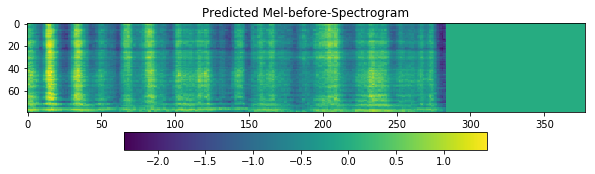

In [20]:
mel_outputs_ = np.reshape(o[0][0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

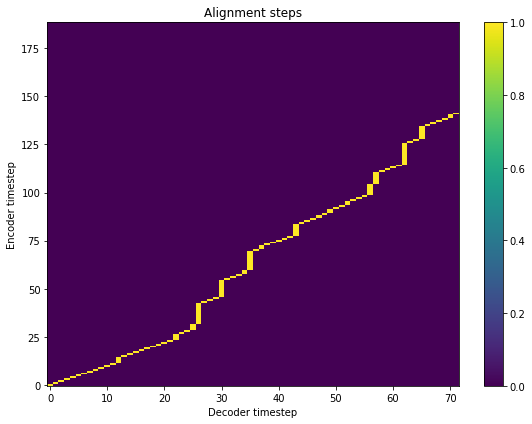

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [ ]:
saver = tf.train.Saver()
saver.save(sess, 'test/model.ckpt')